# Labo 11
Détection de caractéristiques

In [2]:
import imageio as io
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from skimage import data
from skimage.transform import resize
from scipy.signal import correlate2d

## Exercice 1 - Feature matching
Identifier un patch dans `img1` et l'associer à `img2` en utilisant la somme des différences carrées (SSD).

/tmp/ipykernel_62801/224390020.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = io.imread('statue1.PNG')
/tmp/ipykernel_62801/224390020.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = io.imread('statue2.PNG')


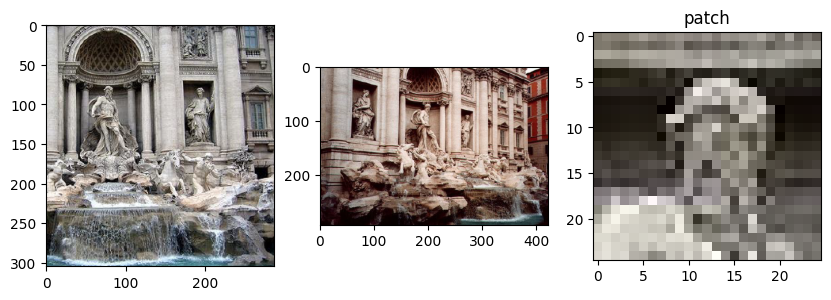

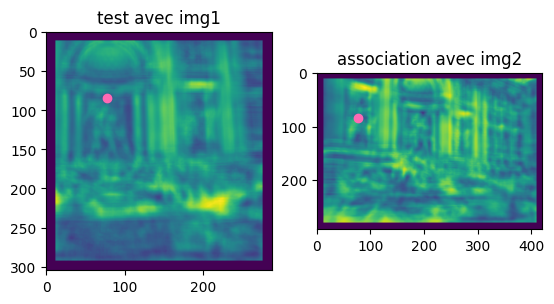

I tried...


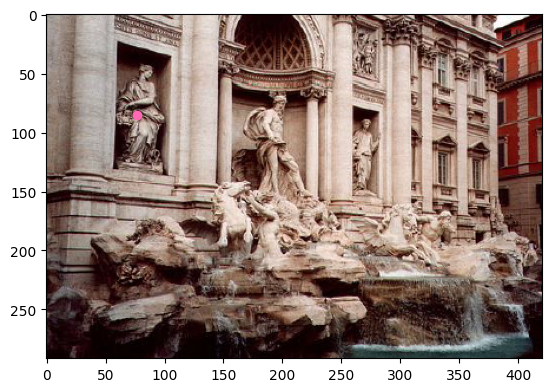

In [3]:
img1 = io.imread('statue1.PNG')
img2 = io.imread('statue2.PNG')

plt.figure(figsize=(10,10))
plt.subplot(131); plt.imshow(img1)
plt.subplot(132); plt.imshow(img2)

y = 73; x = 65
patch = img1[y:y+25, x:x+25]
plt.subplot(133); plt.imshow(patch); plt.title('patch')

plt.show()

def ssd(img, patch):
    m_diff = np.full_like(img, 255.)
    r = patch.shape[0] // 2
    
    for y in range(r, img.shape[0] - r):
        for x in range(r, img.shape[1] - r):
            diff = (img[y-r:y+r+1, x-r:x+r+1] - patch) ** 2
            m_diff[y, x] = diff.sum()
    
    return m_diff
    
test = ssd(img1.mean(axis=2), patch.mean(axis=2))
plt.subplot(121); plt.imshow(test)
lines, columns = np.where(test == test.min())
plt.scatter(columns, lines, color = 'hotpink')
plt.title('test avec img1')

asso = ssd(img2.mean(axis=2), patch.mean(axis=2))
plt.subplot(122); plt.imshow(asso)
lines, columns = np.where(test == test.min())
plt.scatter(columns, lines, color = 'hotpink')
plt.title('association avec img2')

plt.show()

print('I tried...')

plt.imshow(img2)
plt.scatter(columns, lines, color = 'hotpink')
plt.show()

## Exercice 2 - Sift example
Exemple Sift avec opencv
https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/

J'aurais bien voulu le faire, mais il faut payer pour pouvoir utiliser l'algo Sift
```
Both SIFT and SURF authors require license fees for usage of their original algorithms
```

## Exercice 3 - Descripteur de Fourier
Aller chercher le contour de l'objet dans `img` en utilisant les descripteurs de Fourier

/tmp/ipykernel_62801/1282403852.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = io.imread('leaf.png').mean(axis=2)


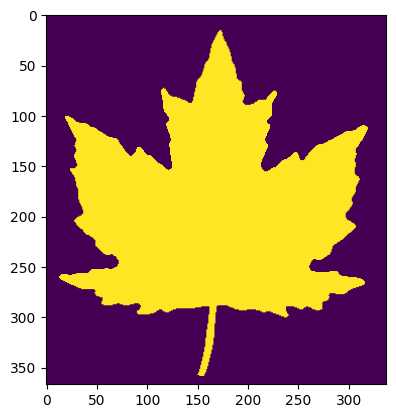

In [4]:
img = io.imread('leaf.png').mean(axis=2)
img[img <= img.min()] = 0
img[img > 0] = 1
img.astype(np.int8)

plt.imshow(img); plt.show()

[array([[359., 156.],
       [359., 155.],
       [359., 154.],
       ...,
       [357., 157.],
       [358., 157.],
       [359., 156.]], shape=(1521, 2))] [[359. 156.]
 [359. 155.]
 [359. 154.]
 ...
 [357. 157.]
 [358. 157.]
 [359. 156.]]
[[359. 156.]
 [359. 155.]
 [359. 154.]
 ...
 [357. 157.]
 [358. 157.]
 [359. 156.]]


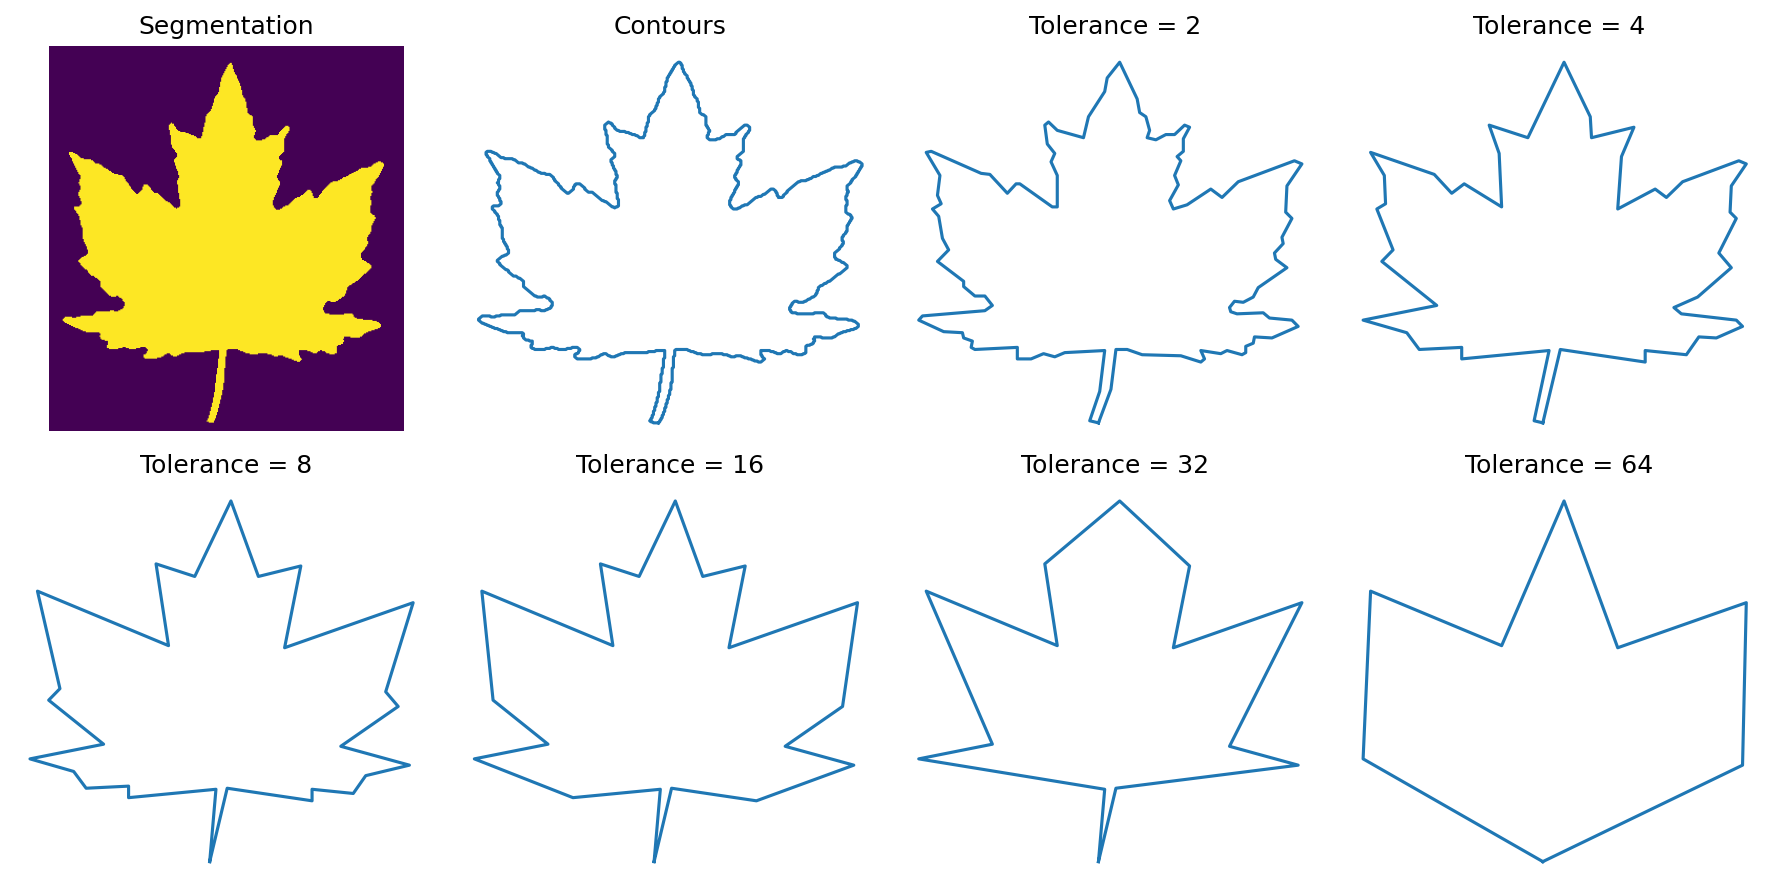

In [11]:
# Extraction de la frontière
c = measure.find_contours(img, level=False)
print(c, c[0])
c = c[0]
print(c)
# Approximation du contour
plt.figure(figsize=(12,6), dpi=150)
plt.subplot(241); plt.imshow(img); plt.axis("off"); plt.title("Segmentation")
plt.subplot(242); plt.plot(c[:,1], c[:,0]); plt.ylim((img.shape[0],0)); plt.axis("off"); plt.title("Contours")

for i, t in enumerate([2,4,8,16,32,64]):
    cmpp = measure.approximate_polygon(c, tolerance=t)
    plt.subplot(2,4,i+3)
    plt.plot(cmpp[:,1], cmpp[:,0])
    plt.xlim((0,img.shape[1]))
    plt.ylim((img.shape[0],0))
    plt.axis("off")
    plt.title(f"Tolerance = {t}")

plt.tight_layout()
plt.show()

[359. 155.]


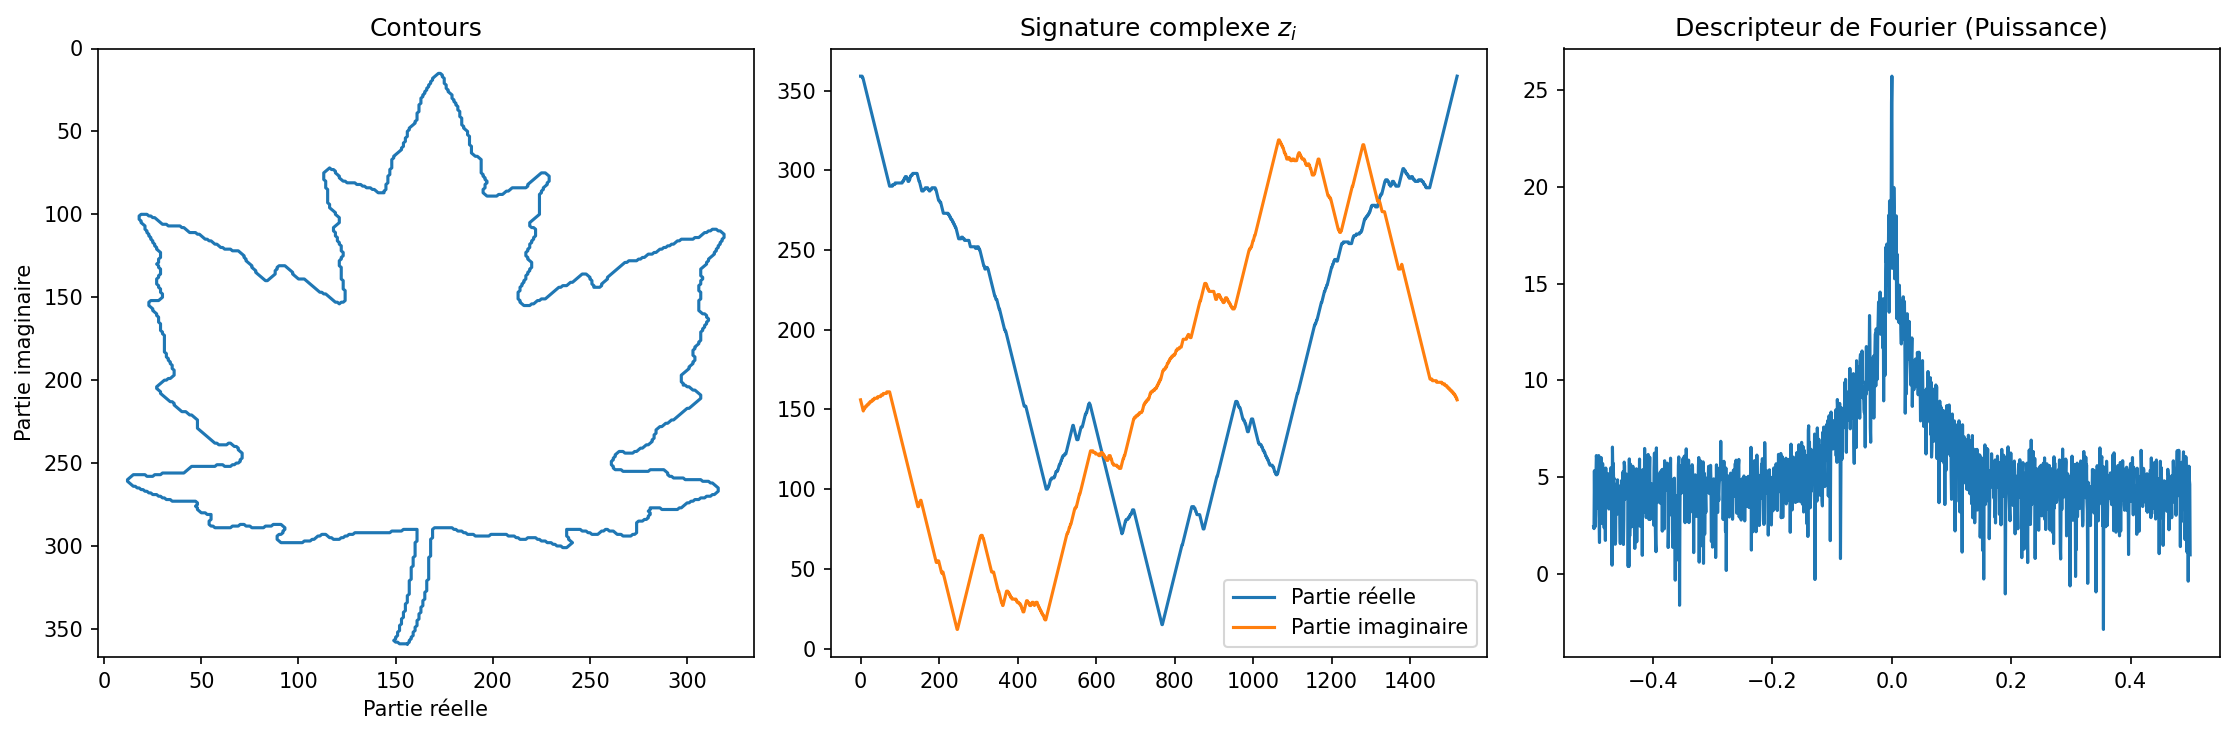

In [7]:
# Descripteur de Fourier
print(c[1,:])
z = c[:,0] + 1j * c[:,1]
z_fft = np.fft.fftshift(np.fft.fft(z))
z_freq = np.fft.fftshift(np.fft.fftfreq(len(z)))

plt.figure(figsize=(15,5), dpi=150)
plt.subplot(131); plt.plot(c[:,1], c[:,0]); plt.ylim((img.shape[0], 0)); plt.title("Contours")
plt.xlabel("Partie réelle")
plt.ylabel("Partie imaginaire")

plt.subplot(132)
plt.plot(z.real, label="Partie réelle")
plt.plot(z.imag, label="Partie imaginaire")
plt.legend()
plt.title("Signature complexe $z_i$")
plt.subplot(133)
plt.plot(z_freq, np.log(np.abs(z_fft**2)))
plt.title("Descripteur de Fourier (Puissance)")
plt.tight_layout()
plt.show()

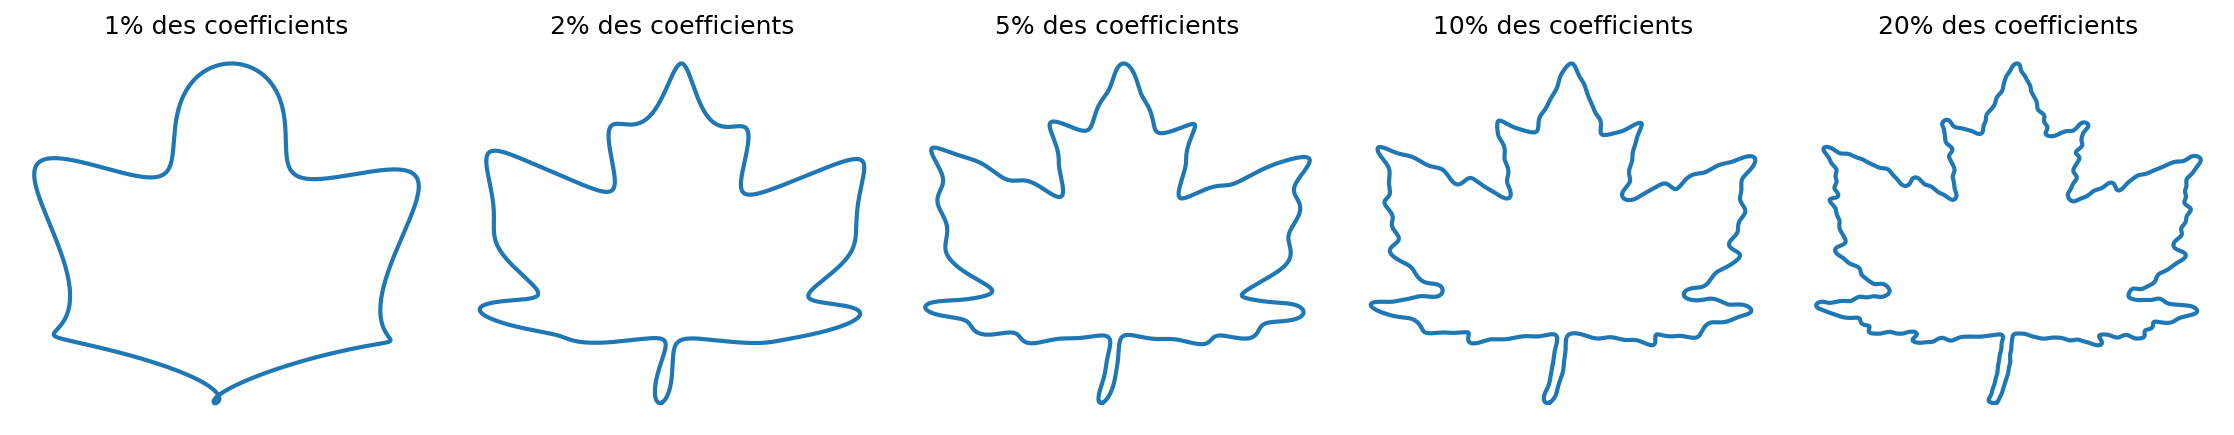

In [163]:
# Approximations
seuils = [0.005,0.01,0.025,0.05,0.1]
nSeuils = len(seuils)
plt.figure(dpi=150,figsize=(3*nSeuils, 3))
for i, s in enumerate(seuils):
    masque = np.abs(z_freq) <= s
    z_fft_p = z_fft * masque
    z_p = np.fft.ifft(np.fft.ifftshift(z_fft_p))
    c_x = z_p.imag
    c_y = img.shape[0] - z_p.real
    plt.subplot(1,nSeuils, i+1)
    plt.plot(c_x,c_y,linewidth=2)
    plt.title(f"{masque.sum() / len(masque) * 100:.0f}% des coefficients")
    plt.axis("off")
plt.tight_layout()
plt.show()